# Doodle Image Classifier

Sam Hoogewind and Corey Campbell

## Setup

In [1]:
try:
    import fastai
except ImportError:
    print("installing fastai...")
    !pip install -Uqq fastai

import torch
from fastai.vision.all import *
# Input tensors get tagged as `TensorImageBW`, and they keep that tag even after going through the model.
# I'm not sure how you're supposed to drop that tag, but this works around a type dispatch error.
TensorImageBW.register_func(F.cross_entropy, TensorImageBW, TensorCategory)

import sys
if sys.platform == "darwin":
    # https://stackoverflow.com/a/64855500/69707
    import os
    os.environ['OMP_NUM_THREADS'] = '1'
    
import numpy as np
import random

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg 

In [2]:
torch.manual_seed(12);

## Process the images

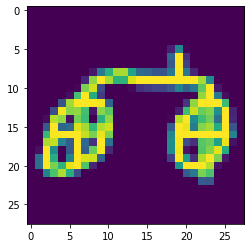

In [3]:
path = Path('/kaggle/input/npybitfile/')
image_files = []
for npy_file in path.glob("*.npy"):
    category_name = npy_file.name[:-4]
    npy_drawings = np.load(npy_file)
    
    npy_drawings.shape
    
    drawing1 = (npy_drawings[0]).reshape(28,28)
    plt.imshow(drawing1);
    
    indices = torch.randperm(len(npy_drawings))[:1000]
    drawing_items = npy_drawings[indices]
    
    os.makedirs('/kaggle/working/{}'.format(category_name + 's'))
    indice = 0
    for image in drawing_items:
        item = image.reshape(28,28)
        i = Image.fromarray(item)
        i.save("/kaggle/working/{}/{}{}.png".format(category_name + 's', category_name, indice))
        indice += 1
        
    img_files = get_image_files("/kaggle/working/{}".format(category_name + 's')).sorted()
    
    image_files.extend(img_files)

In [4]:
len(image_files)

20000

### Get the label for each image

In [5]:
def get_label(filename):
    pattern = r'[0-9]'
    label = re.sub(pattern, '', filename)
    label = label[:-4]
    return label

In [6]:
labels = []
for path in image_files:
    labels.append(get_label(path.name))

In [7]:
len(labels)

20000

In [8]:
dataset_path = Path('kaggle/working')

### Create the dataloaders

In [9]:
dataloaders = ImageDataLoaders.from_lists(
    # What images to use:
    path=dataset_path, fnames=image_files, labels=labels,

    # train-test split parameters:
    # - amount to hold out for validation:
    valid_pct=0.2,
    # - set the seed used for the train-test split (not the training)
    seed=15, 

    # Set batch size
    bs=16,
)

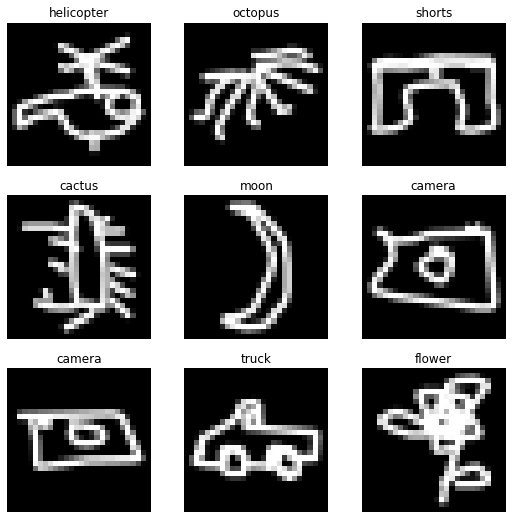

In [10]:
dataloaders.train.show_batch()

In [11]:
print(f"Available categories: {dataloaders.train.vocab}")

Available categories: ['bicycle', 'cactus', 'camera', 'flower', 'helicopter', 'monkey', 'moon', 'mug', 'octopus', 'owl', 'panda', 'shorts', 'strawberry', 'submarine', 'sword', 'telephone', 'tree', 'truck', 'violin', 'windmill']


In [12]:
print(dataloaders.train.n, "training images")
print(dataloaders.valid.n, "validation images")

16000 training images
4000 validation images


### Train the model

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,2.125255,1.774972,0.519250,0.480750,00:53


epoch,train_loss,valid_loss,accuracy,error_rate,time
0,1.422565,1.105219,0.678750,0.321250,00:54
1,1.189315,0.856020,0.753250,0.246750,00:54
2,0.999626,0.764800,0.781500,0.218500,00:53
3,0.904579,0.675827,0.819000,0.181000,00:54
4,0.793715,0.661531,0.819250,0.180750,00:54
5,0.694475,0.650467,0.823500,0.176500,00:55
6,0.675450,0.521860,0.856250,0.143750,00:53
7,0.518429,0.523217,0.848250,0.151750,00:53
8,0.446148,0.601883,0.844000,0.156000,00:53
9,0.346209,0.471242,0.870250,0.129750,00:52


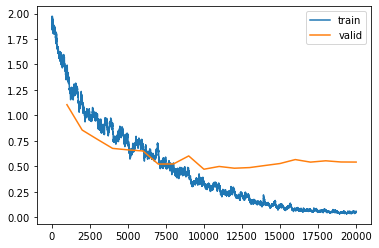

In [13]:
# fastai-specific
learn = vision_learner(
    dls=dataloaders,
    arch=resnet34,
    metrics=[accuracy, error_rate]
)
learn.fine_tune(epochs=20)
learn.recorder.plot_loss()

### View errors

In [14]:
interp = ClassificationInterpretation.from_learner(learn)
interp.print_classification_report()

              precision    recall  f1-score   support

     bicycle       0.96      0.94      0.95       202
      cactus       0.92      0.89      0.91       208
      camera       0.95      0.94      0.94       190
      flower       0.77      0.89      0.83       204
  helicopter       0.84      0.89      0.87       190
      monkey       0.76      0.59      0.66       211
        moon       0.90      0.92      0.91       198
         mug       0.92      0.93      0.92       211
     octopus       0.94      0.94      0.94       208
         owl       0.78      0.81      0.79       229
       panda       0.68      0.70      0.69       174
      shorts       0.96      0.96      0.96       206
  strawberry       0.95      0.92      0.93       191
   submarine       0.89      0.88      0.88       194
       sword       0.93      0.93      0.93       195
   telephone       0.88      0.86      0.87       195
        tree       0.88      0.85      0.87       200
       truck       0.91    

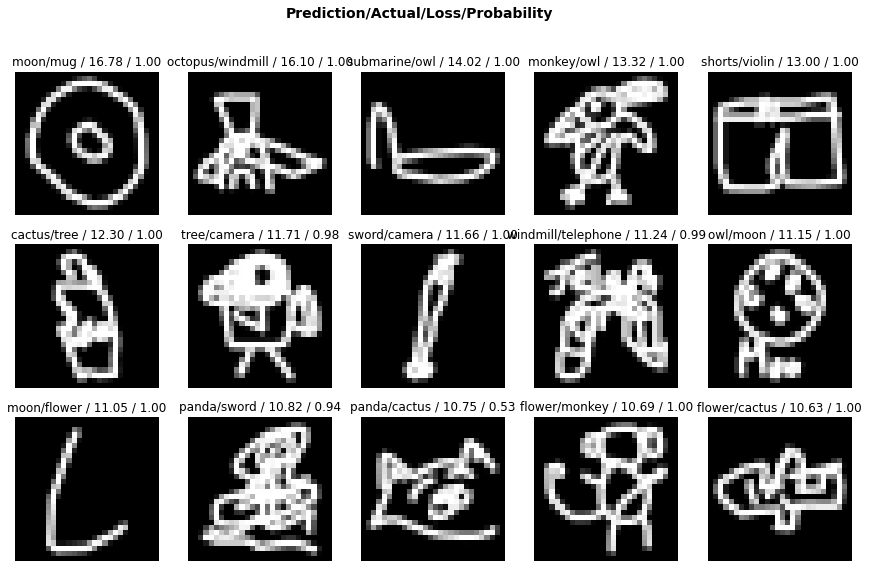

In [15]:
interp.plot_top_losses(15)

### Export model

In [16]:
learn.export('/kaggle/working/doodle_classifier.pkl')